In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
Training_dict = {}
Testing_dict = {}
for file in sorted(os.listdir(r"/Users/matthewweiner/Downloads/dataset/test/data")):
     Testing_dict[file] = pd.read_csv(r"/Users/matthewweiner/Downloads/dataset/test/data/" + file, header = 0, sep = ',', nrows=100)
    
    
for file in sorted(os.listdir(r"/Users/matthewweiner/Downloads/dataset/train/data")):
    Training_dict[file] = pd.read_csv(r"/Users/matthewweiner/Downloads/dataset/train/data/" + file, header = 0, sep = ',', nrows=100)
    
# Read Labels for test set 
test_label = pd.read_excel(r"/Users/matthewweiner/Downloads/dataset/test/labels_spacecraft.xlsx", header = 1)

# Read Labels for training set 
train_label = pd.read_excel(r"/Users/matthewweiner/Downloads/dataset/train/labels.xlsx", header = 1)
train_label.rename(columns={ train_label.columns[0]: "Case", train_label.columns[1]: "Spacecraft", train_label.columns[2]: "Condition"}, inplace=True)
train_label_true = []

for i in np.arange(177):
    if train_label["Condition"][i] == "Normal":
        train_label_true.append(1)
    else:
        train_label_true.append(0) 

training_keys = sorted(os.listdir(r"/Users/matthewweiner/Downloads/dataset/train/data"))
testing_keys = sorted(os.listdir(r"/Users/matthewweiner/Downloads/dataset/test/data"))

answer = pd.read_csv(r"/Users/matthewweiner/Downloads/test data/answer.csv", header = 0, sep = ',', nrows=100)

test_label_true = []
for index, row in answer.iterrows():
    if answer["Test condition"][index] == "Normal":
        test_label_true.append(1)
    else:
        test_label_true.append(0)

test_label_condition = []
for index, row in answer.iterrows():
    if "valve fault" in answer["Test condition"][index]:
        test_label_condition.append(1)
    if "bubble anomaly" in answer["Test condition"][index]:
        test_label_condition.append(2)
    if answer["Test condition"][index] == "Unknown anomaly":
        test_label_condition.append(3)

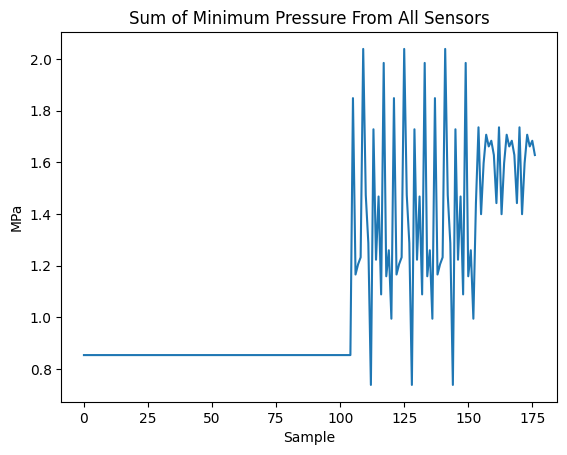

In [3]:
def get_min_pressure(dict, keys):
    min_pressure = np.zeros(np.size(keys))
    for i in range(np.size(keys)):
        df = dict[keys[i]]

        pressure_sensor_1 = df['P1']
        pressure_sensor_2 = df['P2']
        pressure_sensor_3 = df['P3']
        pressure_sensor_4 = df['P4']
        pressure_sensor_5 = df['P5']
        pressure_sensor_6 = df['P6']
        pressure_sensor_7 = df['P7']

        min_pressure[i] = np.min(pressure_sensor_1) + np.min(pressure_sensor_2) + np.min(pressure_sensor_3) + np.min(pressure_sensor_4) + np.min(pressure_sensor_5) + np.min(pressure_sensor_6) + np.min(pressure_sensor_7)

    return min_pressure

min_pressure_training = get_min_pressure(Training_dict, training_keys)

plt.plot(np.arange(177), min_pressure_training)
plt.title('Sum of Minimum Pressure From All Sensors')
plt.xlabel('Sample')
plt.ylabel('MPa')
plt.show()

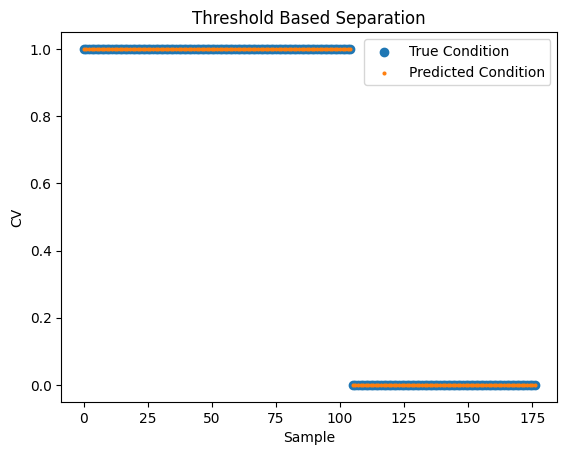

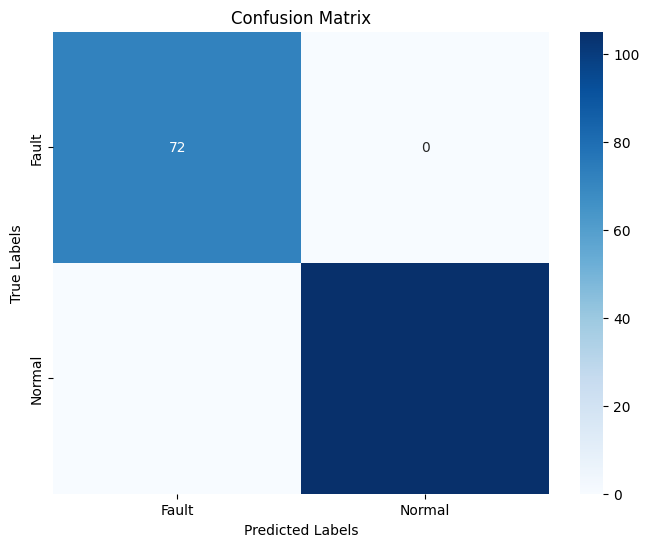

In [4]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def threshold_classifier(min_pressure):
    label_condition = []
    label_pred = []
    
    threshold = 0.8533
    epsilon = 1e-3

    for val in min_pressure:
        if val > threshold + epsilon:
            label_condition.append("Fault")
            label_pred.append(0)
        elif val < threshold - epsilon:
            label_condition.append("Fault")
            label_pred.append(0)
        else:
            label_condition.append("Normal")
            label_pred.append(1)
    
    return label_pred, label_condition

train_label_pred, train_label_condition = threshold_classifier(min_pressure_training)

plt.scatter(np.arange(177), train_label_true)
plt.scatter(np.arange(177), train_label_pred, marker='.', s=15)
plt.legend({"True Condition", "Predicted Condition"})
plt.ylabel("CV")
plt.xlabel("Sample")
plt.title("Threshold Based Separation")
plt.show()

cm = confusion_matrix(train_label_true, train_label_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Fault', 'Normal'], yticklabels=['Fault', 'Normal'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

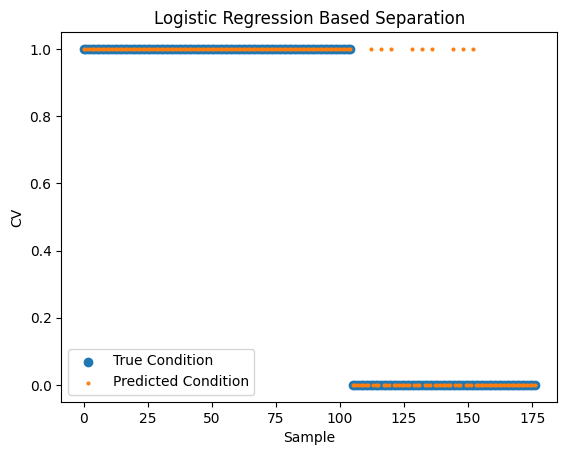

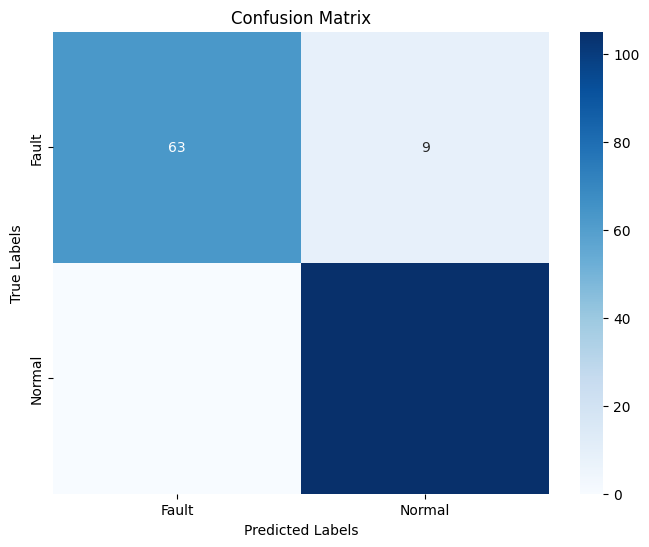

In [5]:
from sklearn.linear_model import LogisticRegression

x_train = np.array(min_pressure_training).reshape(-1, 1)
y_train = np.array(train_label_true)

lr_model = LogisticRegression()
lr_model.fit(x_train, y_train)

y_train_pred = lr_model.predict(x_train)
plt.scatter(np.arange(177), train_label_true)
plt.scatter(np.arange(177), y_train_pred, marker='.', s=15)
plt.legend({"True Condition", "Predicted Condition"})
plt.ylabel("CV")
plt.xlabel("Sample")
plt.title("Logistic Regression Based Separation")
plt.show()

cm = confusion_matrix(train_label_true, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Fault', 'Normal'], yticklabels=['Fault', 'Normal'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

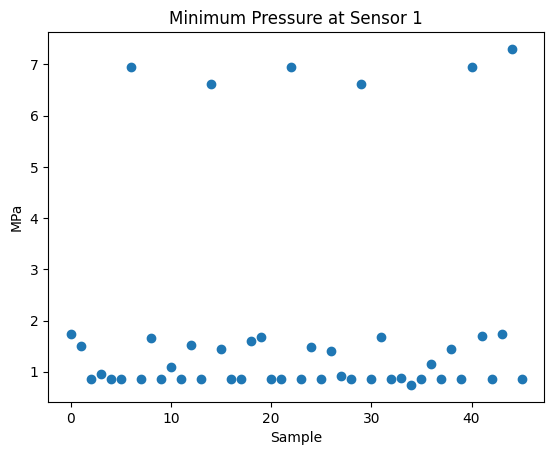

In [6]:
min_pressure_testing = get_min_pressure(Testing_dict, testing_keys)

plt.scatter(np.arange(46), min_pressure_testing) # normal condition min pressure = 0.4622
plt.title('Minimum Pressure at Sensor 1')
plt.xlabel('Sample')
plt.ylabel('MPa')
plt.show()

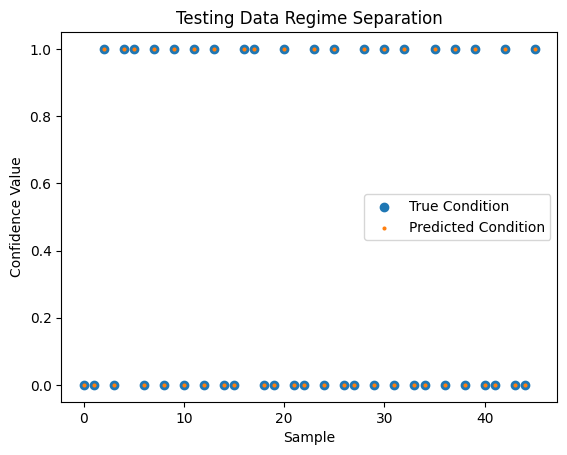

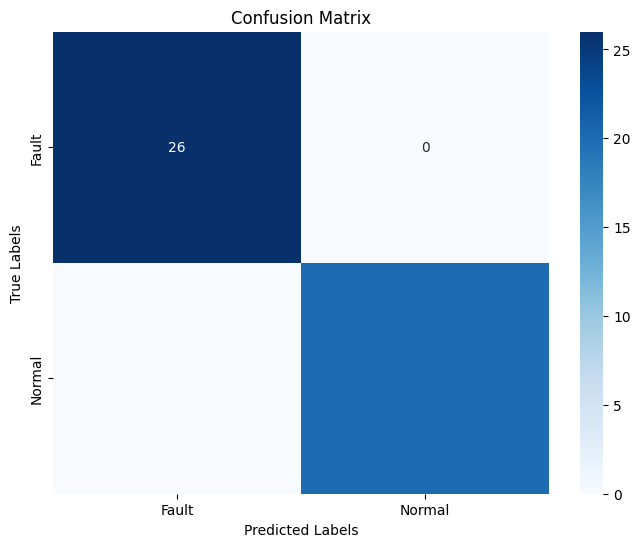

In [7]:
test_label_pred, _ = threshold_classifier(min_pressure_testing)

plt.scatter(np.arange(46), test_label_true)
plt.scatter(np.arange(46), test_label_pred, marker='.', s=15)
plt.ylabel("Confidence Value")
plt.xlabel('Sample')
plt.legend({"True Condition", "Predicted Condition"})
plt.title('Testing Data Regime Separation')
plt.show()

cm = confusion_matrix(test_label_true, test_label_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Fault', 'Normal'], yticklabels=['Fault', 'Normal'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

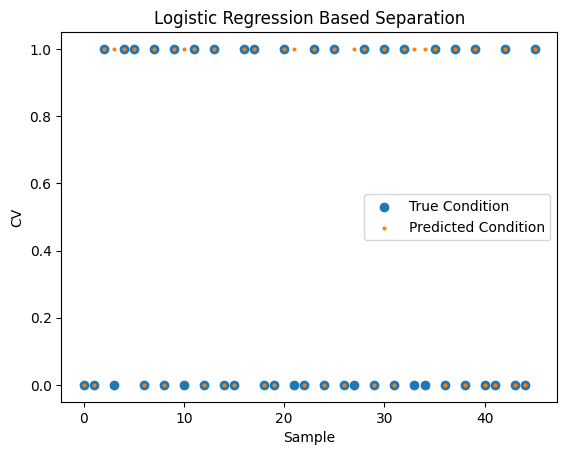

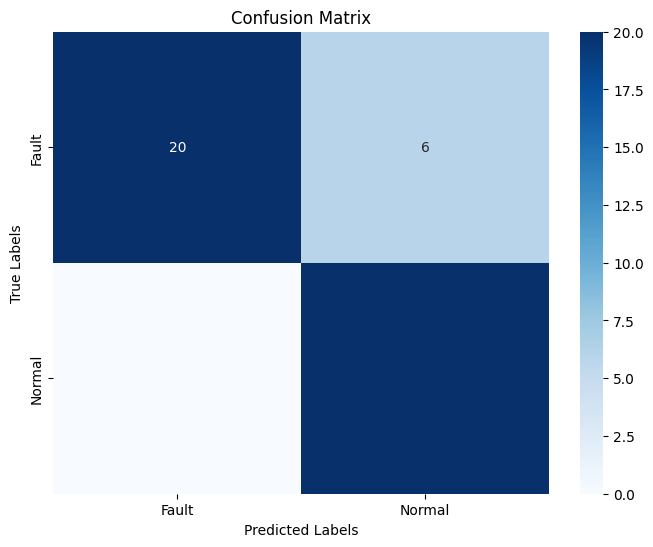

In [8]:
x_test = np.array(min_pressure_testing).reshape(-1, 1)

y_test_pred = lr_model.predict(x_test)
plt.scatter(np.arange(46), test_label_true)
plt.scatter(np.arange(46), y_test_pred, marker='.', s=15)
plt.legend({"True Condition", "Predicted Condition"})
plt.ylabel("CV")
plt.xlabel("Sample")
plt.title("Logistic Regression Based Separation")
plt.show()

cm = confusion_matrix(test_label_true, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Fault', 'Normal'], yticklabels=['Fault', 'Normal'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [9]:
def get_all_sensors(dict, keys):
    all_sensors = []

    for i in range(np.size(keys)):
        df = dict[keys[i]]

        pressure_sensor_1 = df['P1']
        pressure_sensor_2 = df['P2']
        pressure_sensor_3 = df['P3']
        pressure_sensor_4 = df['P4']
        pressure_sensor_5 = df['P5']
        pressure_sensor_6 = df['P6']
        pressure_sensor_7 = df['P7']

        all_sensors.append(pd.concat([pressure_sensor_1, pressure_sensor_2, pressure_sensor_3, pressure_sensor_4, pressure_sensor_5, pressure_sensor_6, pressure_sensor_7]))
    return np.array(all_sensors)

In [10]:
all_sensors_training = get_all_sensors(Training_dict, training_keys)
all_sensors_testing = get_all_sensors(Testing_dict, testing_keys)
fault = []

for val in test_label_pred:
    if val == 0:
        fault.append(all_sensors_testing)

In [11]:
from dtw import *

delta = np.zeros((46, 177))
for i in np.arange(46):
    for j in np.arange(177):
        distance = dtw(all_sensors_testing[i], all_sensors_training[j]).distance
        delta[i][j] = distance

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



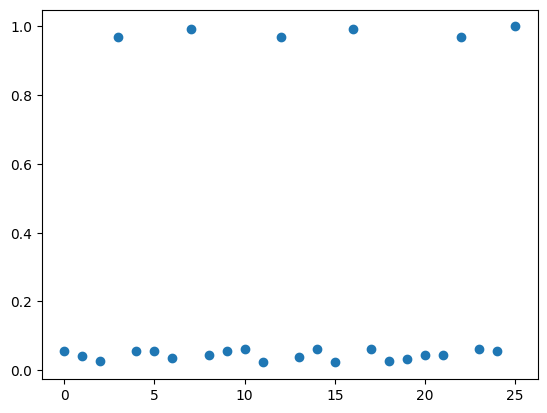

In [12]:
ind = []
for i in np.arange(46):
    if test_label_pred[i] == 1:
        ind.append(i)

fault = np.delete(delta, ind, axis=0)
delta_sum = np.sum(fault, axis=1).reshape(-1, 1)
delta_sum = delta_sum/np.max(delta_sum)

plt.scatter(np.arange(26), delta_sum)
plt.show()

In [13]:
print(delta_sum)
print(2*np.min(delta_sum))
print(3*np.min(delta_sum))

[[0.05554841]
 [0.04100846]
 [0.02773511]
 [0.97024837]
 [0.05503504]
 [0.05613778]
 [0.03651057]
 [0.99243369]
 [0.04513338]
 [0.05626754]
 [0.06258947]
 [0.02233127]
 [0.97024837]
 [0.03710014]
 [0.06204436]
 [0.02433795]
 [0.99243369]
 [0.06258947]
 [0.02713156]
 [0.03108195]
 [0.04501772]
 [0.04513338]
 [0.97024837]
 [0.06145275]
 [0.05554841]
 [1.        ]]
0.04466254289282564
0.06699381433923846


0.04506254289282564


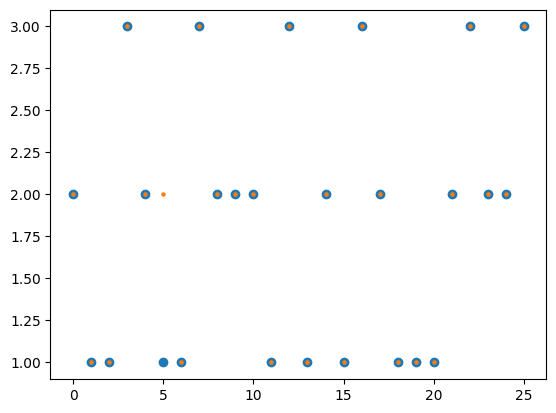

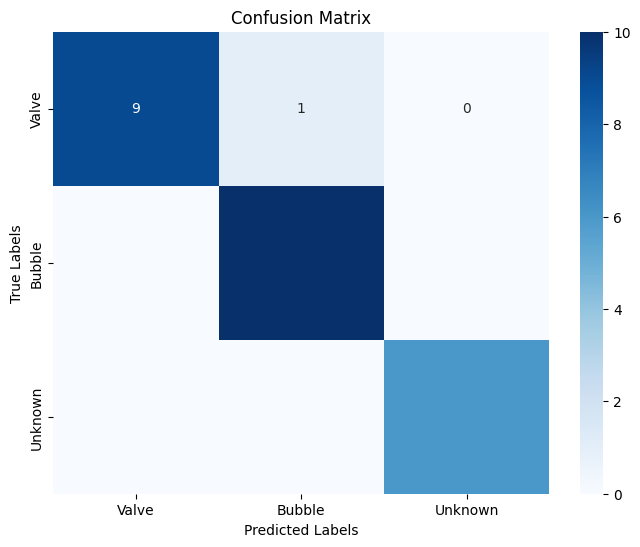

In [24]:
y_pred_condition = []

alpha = 2*np.min(delta_sum) + .0004
print(alpha)
beta = 3*np.min(delta_sum)

for val in delta_sum:
    if val < alpha:
        y_pred_condition.append(1) # valve fault
    elif val < beta:
        y_pred_condition.append(2) # bubble fault
    else:
        y_pred_condition.append(3) # unknown

plt.scatter(np.arange(26), test_label_condition)
plt.scatter(np.arange(26), y_pred_condition, marker='.', s=20)
plt.show()

cm = confusion_matrix(test_label_condition, y_pred_condition)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Valve", 'Bubble', 'Unknown'], yticklabels=["Valve", 'Bubble', 'Unknown'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

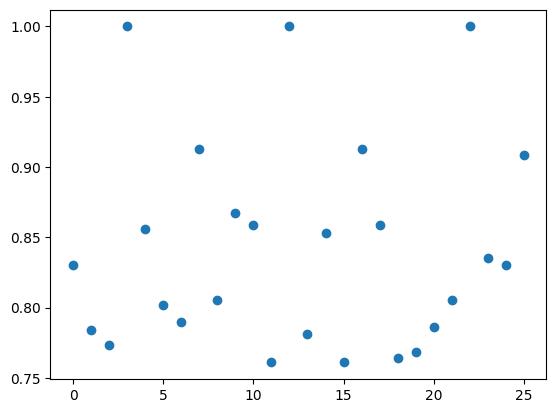

[[0.83031339]
 [0.78373241]
 [0.77333845]
 [1.        ]
 [0.8556879 ]
 [0.80167768]
 [0.78943513]
 [0.91288956]
 [0.80537486]
 [0.86733751]
 [0.85856542]
 [0.76097382]
 [1.        ]
 [0.78151759]
 [0.8529499 ]
 [0.76125286]
 [0.91288956]
 [0.85856542]
 [0.76406062]
 [0.7685077 ]
 [0.78652273]
 [0.80537486]
 [1.        ]
 [0.8351267 ]
 [0.83031339]
 [0.90873895]]


In [21]:
import numpy as np
from fastdtw import fastdtw
import matplotlib.pyplot as plt

# Assuming all_sensors_testing, all_sensors_training, and test_label_pred are defined

delta = np.zeros((46, 177))

for i in range(46):
    for j in range(177):
        _, path = fastdtw(all_sensors_testing[i], all_sensors_training[j])
        distance = len(path)
        delta[i][j] = distance

ind = [i for i in range(46) if test_label_pred[i] == 1]

fault = np.delete(delta, ind, axis=0)
delta_sum = np.sum(fault, axis=1).reshape(-1, 1)
delta_sum = delta_sum / np.max(delta_sum)

plt.scatter(np.arange(46 - len(ind)), delta_sum)
plt.show()

print(delta_sum)

0.805


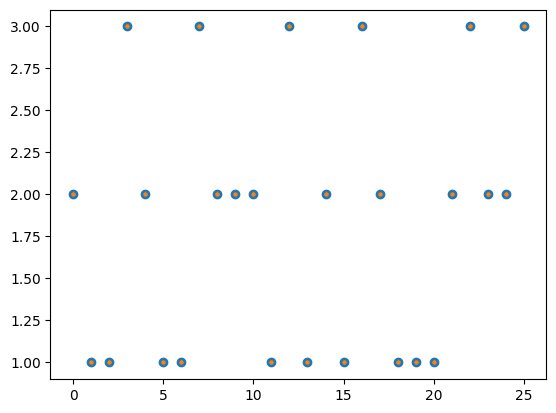

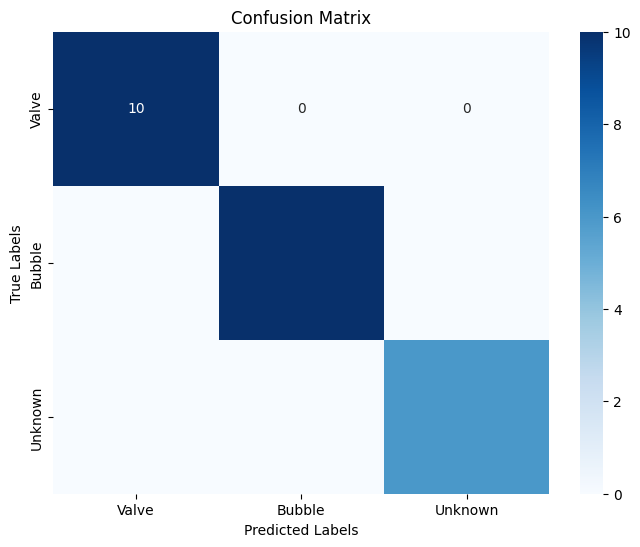

In [25]:
y_pred_condition = []

alpha = 0.805
print(alpha)
beta = .9

for val in delta_sum:
    if val < alpha:
        y_pred_condition.append(1) # valve fault
    elif val < beta:
        y_pred_condition.append(2) # bubble fault
    else:
        y_pred_condition.append(3) # unknown

plt.scatter(np.arange(26), test_label_condition)
plt.scatter(np.arange(26), y_pred_condition, marker='.', s=20)
plt.show()

cm = confusion_matrix(test_label_condition, y_pred_condition)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Valve", 'Bubble', 'Unknown'], yticklabels=["Valve", 'Bubble', 'Unknown'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()